In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 4.9MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFs3fv44rx26LtywxQpo8C_OoEiNjBqCOHOFZ2onoMo4EWv1G1-tcw
Mounted at /gdrive


In [6]:
# xml's sample code learned from https: //www.youtube.com/watch?v=PNNg4xKbCtA
#https://docs.python.org/3.4/library/xml.etree.elementtree.html
import xml.etree.ElementTree as ET
column_list=[]
file= '/gdrive/My Drive/reports/1.xml'
tree = ET.parse(file)
root = tree.getroot()
for child in root:
    if child.tag=='MedlineCitation':
        for attr in child:
            if attr.tag=='Article':
                for i in attr:
                    if i.tag=='Abstract':
                        for name in i:
                            if name.get('Label')=='COMPARISON':
                                comparison=name.text
                            elif name.get('Label')=='INDICATION':
                                indication=name.text
                            elif name.get('Label')=='FINDINGS':
                                findings=name.text
                            elif name.get('Label')=='IMPRESSION':
                                 impression=name.text
                                
        for p_image in root.findall('parentImage'):
            idd = p_image.get('id')
            print("\nCOMPARISON:",comparison)
            print("\nINDICATION:",indication)
            print("\nFINDINGS:",findings)
            print("\nIMPRESSION:",impression)
            print("\nid:",idd)
            break


COMPARISON: None.

INDICATION: Positive TB test

FINDINGS: The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.

IMPRESSION: Normal chest x-XXXX.

id: CXR1_1_IM-0001-3001


In [7]:
import os
directory = '/gdrive/My Drive/reports'
number_of_report_files= os.listdir(directory) 
print("Total number of report files:",len(number_of_report_files))

Total number of report files: 3955


In [8]:
# this code is for extracting data from xml files 
# xml's sample code learned from https: //www.youtube.com/watch?v=PNNg4xKbCtA
#https://docs.python.org/3.4/library/xml.etree.elementtree.html
from tqdm import tqdm
from os import listdir 
from os import path
id_impression=dict()
id_finding=dict()
directory = '/gdrive/My Drive/reports'

for filename in tqdm(listdir(directory)):
    if filename.endswith(".xml"):
        f=path.join(directory,filename)
        #f='C:/Users/Admin/Downloads/Medical_case_study/reports/'+filename
        #print(filename)
        #count=0
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag=='MedlineCitation':
                for attr in child:
                    if attr.tag=='Article':
                        for i in attr:
                            if i.tag=='Abstract':
                                for name in i:
                                    if name.get('Label')=='FINDINGS':
                                        finding=name.text
                                    elif name.get('Label')=='IMPRESSION':
                                        impression=name.text
                                
        for p_image in root.findall('parentImage'):
            idd = p_image.get('id')
            id_impression[idd]=impression
            id_finding[idd]=finding
            for i in range(1,3):
                id=idd+str(i)
                id_impression[id]=impression
                id_finding[id]=finding

100%|██████████| 3955/3955 [25:58<00:00,  2.54it/s]


In [9]:
count1=0
#finding none values in impression
for k,v in id_impression.items(): 
    if id_impression[k] is None:
        count1=count1+1
print("Impression data contains",count1,"None Values")

Impression data contains 156 None Values


In [10]:
count=0
#finding none values in finding
for k,v in id_finding.items(): 
    if id_finding[k] is None:
        count=count+1
print("Finding data contains",count,"None Values")

Finding data contains 2991 None Values


In [11]:
count=0
#finding none values in findings and impressions
for k,v in id_finding.items(): 
    if (id_finding[k] is None) and (id_impression[k] is None) :
        count=count+1
print("There are",count,"datapoints whose Finding and impressions data are None")

There are 120 datapoints whose Finding and impressions data are None


In [12]:
count=0
#finding none values in finding or impression
for k,v in id_finding.items(): 
    if (id_finding[k] is None) or (id_impression[k] is None) :
        count=count+1
print("There are",count,"datapoints whose Finding or impressions data are None")

There are 3027 datapoints whose Finding or impressions data are None


In [13]:
# removing none impressions
id_impression_none_removed = { k : v for k,v in id_impression.items() if v is not None}
print("After removing None contained impressions,number of final impressions: "+str(len(id_impression)) +" - "+str(count1) +"="+str(len(id_impression_none_removed)))

After removing None contained impressions,number of final impressions: 22410 - 156=22254


In [14]:

#finding none values in finding 
count=0
finding_for_2nd_model=dict()
#impression_for_2nd_model=dict()
for k,v in id_finding.items(): 
    if (id_finding[k] is None) or (id_impression[k] is None) :
        count=count+1
        continue
    else:
        finding_for_2nd_model[k]=v
        #impression_for_2nd_model[k]=id_impression[k]
        
print("There are",count,"datapoints whose Finding or impressions data are None , so we have removed them.")
print("Number of final Finding datapoints: "+str(len(id_finding))+" - ",count,"=",len(finding_for_2nd_model))

There are 3027 datapoints whose Finding or impressions data are None , so we have removed them.
Number of final Finding datapoints: 22410 -  3027 = 19383


In [15]:
import re
def clean_descriptions(descriptions,add_token): 
    """this function cleans decription text"""
    descriptionss=dict()
    for key, desc in descriptions.items(): 
        sent = desc.replace('x-XXXX',' ')
        sent = sent.lower()  
        sent = sent.replace('xxxx',' ')     
        sent = sent.replace('x-xxxx',' ')
        sent = re.sub('[^A-Za-z]+', ' ', sent)  
        if add_token=='yes':
            sent = 'startseq ' +sent+ ' endseq' 
        descriptionss[key]=sent.strip()
    return descriptionss

cleaned_id_impressions = clean_descriptions(id_impression_none_removed,'yes')
cleaned_id_findings = clean_descriptions(finding_for_2nd_model,'no')

In [16]:
# after cleaning impression data 
count=0
for k,v in cleaned_id_impressions.items():
    if count!=1:
        print(k,"\t",v)
        count+=1

CXR3690_IM-1841-1001 	 startseq  stable cardiomegaly without acute disease  endseq


In [17]:
# after cleaning findings data 
count=0
for k,v in cleaned_id_findings.items():
    if count!=1:
        print(k,"\t",v,"\n")
        count+=1

CXR3690_IM-1841-1001 	 the heart is again enlarged aorta is tortuous the lungs are hypoinflated but clear no pleural effusion or pneumothorax is seen 



In [18]:
type(cleaned_id_findings)

dict

In [19]:
df = pd.DataFrame.from_dict(cleaned_id_findings,orient='index',columns=['sentence'])
df.head()

,sentence
CXR3690_IM-1841-1001,the heart is again enlarged aorta is tortuous ...
CXR3690_IM-1841-10011,the heart is again enlarged aorta is tortuous ...
CXR3690_IM-1841-10012,the heart is again enlarged aorta is tortuous ...
CXR3690_IM-1841-2001,the heart is again enlarged aorta is tortuous ...
CXR3690_IM-1841-20011,the heart is again enlarged aorta is tortuous ...


In [23]:
df.to_csv('data_find.csv')
!cp data_find.csv "/gdrive/My Drive/"

In [25]:
df2 = df.tail(2500)
df2.head()

,sentence
CXR1461_IM-0299-20012,the heart is normal in size the mediastinum is...
CXR1404_IM-0258-1001,no focal lung consolidation heart size and pul...
CXR1404_IM-0258-10011,no focal lung consolidation heart size and pul...
CXR1404_IM-0258-10012,no focal lung consolidation heart size and pul...
CXR1404_IM-0258-2001,no focal lung consolidation heart size and pul...


In [26]:
df2.to_csv('last_data.csv')
!cp last_data.csv "/gdrive/My Drive/"

In [ ]:
df['label'] = np.random.randint(0,2,len(df))
df.head(5)

,sentence,label
CXR3690_IM-1841-1001,the heart is again enlarged aorta is tortuous ...,0
CXR3690_IM-1841-10011,the heart is again enlarged aorta is tortuous ...,0
CXR3690_IM-1841-10012,the heart is again enlarged aorta is tortuous ...,0
CXR3690_IM-1841-2001,the heart is again enlarged aorta is tortuous ...,1
CXR3690_IM-1841-20011,the heart is again enlarged aorta is tortuous ...,0


In [ ]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 849286.67B/s]


Tokenize the first sentence:
['[CLS]', 'the', 'heart', 'is', 'again', 'enlarged', 'ao', '##rta', 'is', 'tor', '##tu', '##ous', 'the', 'lungs', 'are', 'h', '##yp', '##oin', '##fl', '##ated', 'but', 'clear', 'no', 'pl', '##eur', '##al', 'e', '##ff', '##usion', 'or', 'p', '##ne', '##um', '##otho', '##ra', '##x', 'is', 'seen', '[SEP]']


In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
type(df.sentence.dtype)

numpy.dtype

In [ ]:
#encoded = [train_labels.word2index[w] for w in df.sentence.values.split(' ')]

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:09<00:00, 41798231.99B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  #print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  #print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch: 100%|██████████| 4/4 [19:06<00:00, 286.53s/it]


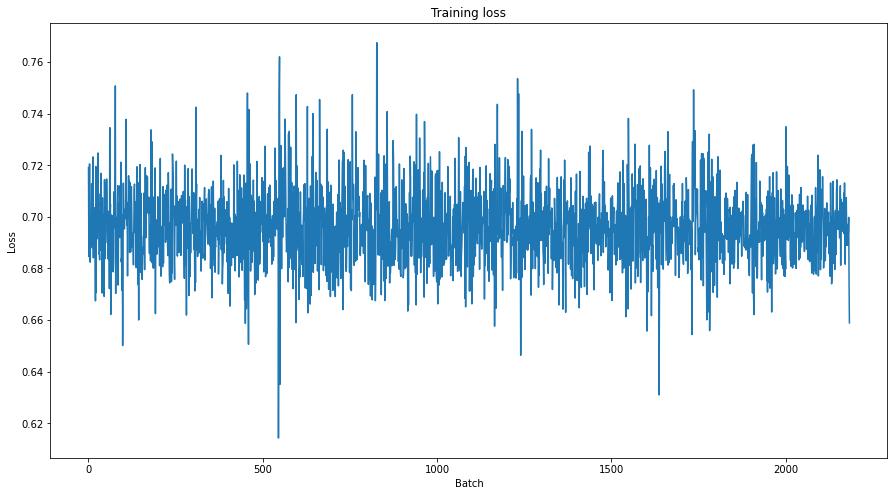

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
df1 = df.head(50)
df1.head(20)

,sentence,label
CXR3690_IM-1841-1001,the heart is again enlarged aorta is tortuous ...,0
CXR3690_IM-1841-10011,the heart is again enlarged aorta is tortuous ...,0
CXR3690_IM-1841-10012,the heart is again enlarged aorta is tortuous ...,0
CXR3690_IM-1841-2001,the heart is again enlarged aorta is tortuous ...,1
CXR3690_IM-1841-20011,the heart is again enlarged aorta is tortuous ...,0
CXR3690_IM-1841-20012,the heart is again enlarged aorta is tortuous ...,0
CXR3691_IM-1842-1001,the heart is normal in size the mediastinum is...,0
CXR3691_IM-1842-10011,the heart is normal in size the mediastinum is...,1
CXR3691_IM-1842-10012,the heart is normal in size the mediastinum is...,1
CXR3691_IM-1842-3003,the heart is normal in size the mediastinum is...,1


In [ ]:
#df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df1.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df1.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [ ]:
matthews_set

[0.0, 0.0]

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [ ]:
matthews_corrcoef(flat_true_labels, flat_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0